# DeepWalk

(34, 34)


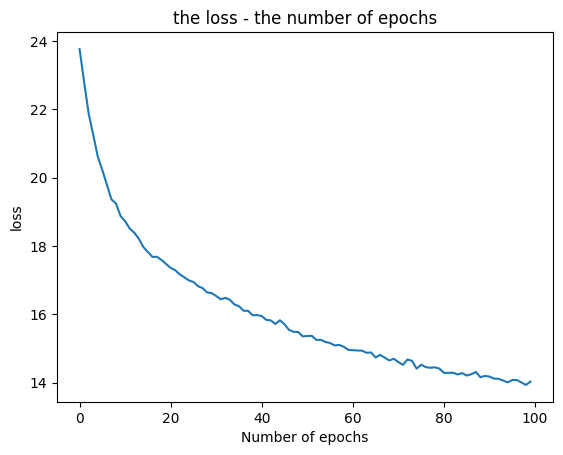

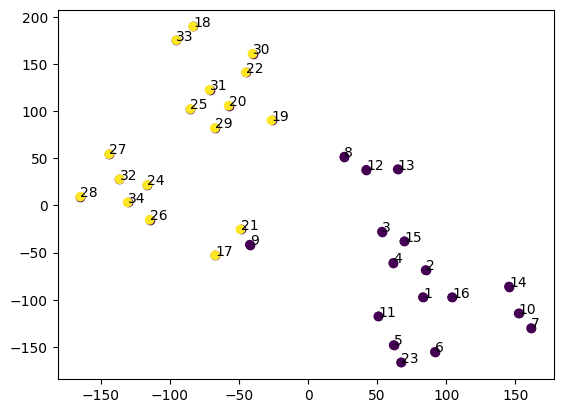

In [4]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from matplotlib import pyplot as plt 
np.random.seed(15)


#Load data
adjlist = nx.read_adjlist("./data/karate_club.adjlist", nodetype=int)
karate_label = np.loadtxt("./data/karate_label.txt")
Graph = nx.read_adjlist("./data/karate_club.adjlist", nodetype=int)
node_number = nx.to_pandas_adjacency(Graph).columns


adj = nx.to_numpy_array(adjlist)
#label = karate_label[:,-1]

print(adj.shape)
#print(label.shape)

#Activation function
def softmax(x):
    c = np.max(x)
    b = x-c
    exp_x = np.exp(b)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
    return y

#Fully connected layer
class ann:
    def __init__(self, input_size, hidden_size, output_size):
        # setting the shape of the layer and putting random inital value
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, output_size)

    # Calculating the Values
    def gradient(self, x, y):
        # forward
        W1, W2 = self.params['W1'], self.params['W2']
        h = np.dot(x, W1)
        # H = softmax(U)

        U2 = np.dot(h, W2)
        Y = softmax(U2)

        diff = (Y - y)  # 34*1

        ERR2 = np.outer(h, diff)

        # backpropagation
        # ERR2 = (-np.log(np.abs(Y-y)))*Y*(1-Y)
        ERR = np.outer(x, np.dot(W2, diff))

        return ERR, ERR2, diff, Y

w = 3 #window_size w
d = 4 #embedding size d
r = 10 # walks per vertex
t = 10 # walk length
learning_rate = 0.0001

#Params
n_network = ann(input_size = 34,hidden_size = d,output_size = 34)
#P = np.random.random((34,d)) # Work as W1 (input_size,hidden_size)
#Q = np.random.random((d,34)) # work as W2 (hidden_size, input_size)

def random_walk(vertex, t):
    ans = []
    ans.append(vertex)

    while True:
        # stop untill the window size get t
        if len(ans) == t:
            return ans

        # check nearest vertexs
        vertex_adj_list = list(adj[vertex])
        near_vertex_index = np.nonzero(vertex_adj_list)

        # choose the nearess vertex randomly
        get_vertex = np.random.choice(list(near_vertex_index[0]), 1)
        ans.append(get_vertex[0])
        vertex = get_vertex[0]


def skipgram(W, w, loss):
    new_loss = np.zeros(34)
    loss = 0
    for idx, vertex in enumerate(W):
        # making u_list considering w
        start = idx - w
        end = idx + w
        if start < 0:
            start = 0
        if end >= len(W):
            end = len(W) - 1

        u_list = []
        u_list.extend(W[start:idx])
        u_list.extend(W[idx + 1:end + 1])

        # calculating each u from u_list
        for each_u in u_list:
            # input, ouput with one-hot encoding
            input_vertex = np.zeros(34)
            y_pred = np.zeros(34)
            v = vertex
            u = each_u
            input_vertex[v] = 1
            y_pred[u] = 1

            # gradient (forward,backpropa)

            ERR, ERR2, diff, Y = n_network.gradient(input_vertex, y_pred)
            # updata params
            n_network.params['W1'] -= learning_rate * ERR
            n_network.params['W2'] -= learning_rate * ERR2
            # n_network.params['W2'] -= np.reshape(learning_rate * ERR2 * H.T, (d,34))

            # calculating loss
            loss += -np.log(Y[each_u])
        # new_loss = new_loss / len(u_list)
    return loss


epoch = 100
epoch_loss2 = []
loss = np.zeros((34, 34))
for _ in range(epoch):
    epoch_loss = 0
    for i in range(r):
        O = np.arange(34)
        np.random.shuffle(O)

        for vertex in O:
            W = random_walk(vertex, t)
            loss = skipgram(W, w, loss)
            epoch_loss += (loss / len(W))

    # h = np.dot(adj[1],W1)
    # H = softmax(U)

    # U2 = np.dot(h,W2)
    # Y = softmax(U2)
    # aa = np.mean(-np.log(Y -adj[1]))
    epoch_loss2.append(np.mean(epoch_loss) / (len(O) * r))
    # calculating loss
    # n_network.params['W1']


from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

plt.plot(epoch_loss2)
plt.title("the loss - the number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("loss")
plt.show()

nums = np.identity(34)
W1 = n_network.params['W1']
output = np.dot(nums , W1)
adj = nx.to_numpy_array(adjlist)
label = karate_label[:,-1]


node_number
label
label_fix = []
for i in node_number:
    tem = label[i]
    label_fix.append(tem)




import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(learning_rate=100,perplexity=5)
transformed = model.fit_transform(output)
xs = transformed[:,0]
ys = transformed[:,1]

for i in range(len(xs)):
    plt.scatter(xs[i],ys[i],c = node_number[i])
    plt.text(xs[i],ys[i],i+1)
plt.scatter(xs,ys,c=label_fix)
#plt.text(xs,ys)
plt.show()

# node2vec

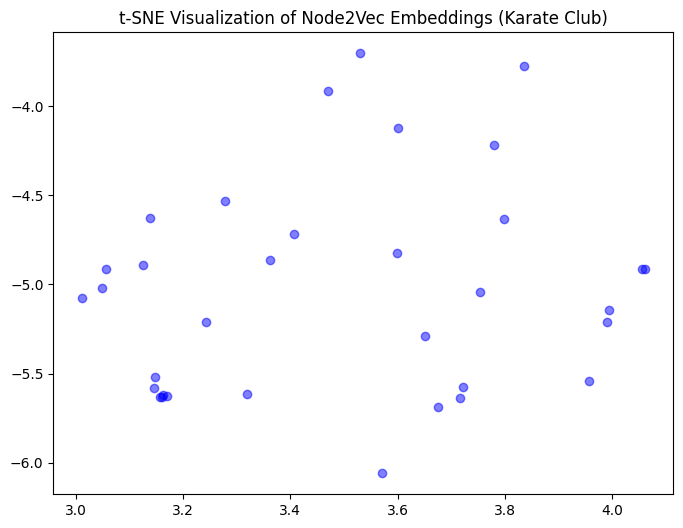

In [40]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

class Word2Vec:
    def __init__(self, dimensions=128, window=5, learning_rate=0.025):
        self.dimensions = dimensions
        self.window = window
        self.learning_rate = learning_rate

    def initialize_weights(self, vocab_size):
        self.input_weights = np.random.uniform(-0.5 / self.dimensions, 0.5 / self.dimensions, (vocab_size, self.dimensions))
        self.output_weights = np.random.uniform(-0.5 / self.dimensions, 0.5 / self.dimensions, (vocab_size, self.dimensions))

    def train(self, corpus, epochs=1):
        vocab = set()
        for sentence in corpus:
            vocab.update(sentence)
        vocab = list(vocab)
        vocab_size = len(vocab)
        self.initialize_weights(vocab_size)

        for _ in range(epochs):
            for sentence in corpus:
                for i, target_word in enumerate(sentence):
                    target_index = vocab.index(target_word)
                    for j in range(max(0, i - self.window), min(len(sentence), i + self.window + 1)):
                        if j != i:
                            context_word = sentence[j]
                            context_index = vocab.index(context_word)
                            self.update_weights(target_index, context_index)

    def update_weights(self, target_index, context_index):
        input_vector = self.input_weights[target_index]
        output_vector = self.output_weights[context_index]
        score = np.dot(input_vector, output_vector)
        exp_score = np.exp(score)
        grad = exp_score / (1 + exp_score)
        grad = (1 - grad) * self.learning_rate
        self.input_weights[target_index] += grad * output_vector
        self.output_weights[context_index] += grad * input_vector

class Node2Vec:
    def __init__(self, graph, dimensions=128, walk_length=80, num_walks=10, p=1, q=1):
        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q

    def _node2vec_walk(self, walk_length, start_node):
        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            neighbors = list(self.graph.neighbors(cur))
            if len(neighbors) > 0:
                if len(walk) == 1:
                    walk.append(random.choice(neighbors))
                else:
                    prev = walk[-2]
                    next_node = self._weighted_random_walk(cur, prev)
                    walk.append(next_node)
            else:
                break
        return walk

    def _weighted_random_walk(self, cur, prev):
        neighbors = list(self.graph.neighbors(cur))
        weights = [self._get_weight(cur, nbr, prev) for nbr in neighbors]
        return random.choices(neighbors, weights=weights)[0]

    def _get_weight(self, cur, nbr, prev):
        if prev == nbr:
            return 1 / self.p
        elif self.graph.has_edge(cur, nbr):
            return 1
        else:
            return 1 / self.q

    def generate_walks(self):
        walks = []
        nodes = list(self.graph.nodes())
        for _ in range(self.num_walks):
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self._node2vec_walk(self.walk_length, node))
        return walks

    def learn_embeddings(self, walks):
        corpus = walks  # Treat walks as sentences for Word2Vec
        w2v = Word2Vec(dimensions=self.dimensions)
        w2v.train(corpus)
        self.embeddings = {node: w2v.input_weights[i] for i, node in enumerate(self.graph.nodes())}

# Load Karate Club dataset
G = nx.karate_club_graph()

# Initialize node2vec
node2vec = Node2Vec(G)

# Generate walks
walks = node2vec.generate_walks()

# Learn embeddings
node2vec.learn_embeddings(walks)

# Extract node embeddings
embeddings = np.array([node2vec.embeddings[node] for node in sorted(G.nodes())])

# Visualize embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 6))
for i in range(len(X_embedded)):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], c='b', label='Node', alpha=0.5)
plt.title('t-SNE Visualization of Node2Vec Embeddings (Karate Club)')
plt.show()


# node2vec+

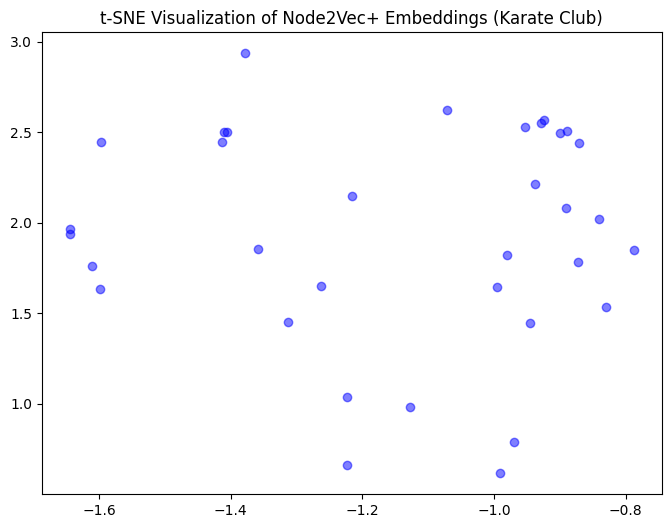

In [44]:
import numpy as np
import random
import networkx as nx
from sklearn.manifold import TSNE
from multiprocessing import Pool

class Word2Vec:
    def __init__(self, dimensions=128, window=5, learning_rate=0.025):
        self.dimensions = dimensions
        self.window = window
        self.learning_rate = learning_rate

    def initialize_weights(self, vocab_size):
        self.input_weights = np.random.uniform(-0.5 / self.dimensions, 0.5 / self.dimensions, (vocab_size, self.dimensions))
        self.output_weights = np.random.uniform(-0.5 / self.dimensions, 0.5 / self.dimensions, (vocab_size, self.dimensions))

    def train(self, corpus, epochs=1):
        vocab = set()
        for sentence in corpus:
            vocab.update(sentence)
        vocab = list(vocab)
        vocab_size = len(vocab)
        self.initialize_weights(vocab_size)

        for _ in range(epochs):
            for sentence in corpus:
                for i, target_word in enumerate(sentence):
                    target_index = vocab.index(target_word)
                    for j in range(max(0, i - self.window), min(len(sentence), i + self.window + 1)):
                        if j != i:
                            context_word = sentence[j]
                            context_index = vocab.index(context_word)
                            self.update_weights(target_index, context_index)

    def update_weights(self, target_index, context_index):
        input_vector = self.input_weights[target_index]
        output_vector = self.output_weights[context_index]
        score = np.dot(input_vector, output_vector)
        exp_score = np.exp(score)
        grad = exp_score / (1 + exp_score)
        grad = (1 - grad) * self.learning_rate
        self.input_weights[target_index] += grad * output_vector
        self.output_weights[context_index] += grad * input_vector

class Node2VecPlus:
    def __init__(self, graph, dimensions=128, walk_length=80, num_walks=10, p=1, q=1, num_workers=4):
        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.num_workers = num_workers

    def generate_walks(self):
        walks = {}
        nodes = list(self.graph.nodes())
        with Pool(self.num_workers) as pool:
            results = pool.map(self._generate_walks_for_node, nodes)
            for walks_for_node in results:
                walks.update(walks_for_node)
        return list(walks.values())

    def _generate_walks_for_node(self, node):
        walks_for_node = []
        for _ in range(self.num_walks):
            walk = self._node2vec_walk(self.walk_length, node)
            walks_for_node.append(tuple(walk))
        return {tuple(walk): walk for walk in walks_for_node}

    def _node2vec_walk(self, walk_length, start_node):
        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            neighbors = list(self.graph.neighbors(cur))
            if len(neighbors) > 0:
                if len(walk) == 1:
                    walk.append(random.choice(neighbors))
                else:
                    prev = walk[-2]
                    next_node = self._weighted_random_walk(cur, prev)
                    walk.append(next_node)
            else:
                break
        return walk

    def _weighted_random_walk(self, cur, prev):
        neighbors = list(self.graph.neighbors(cur))
        weights = [self._get_weight(cur, nbr, prev) for nbr in neighbors]
        return random.choices(neighbors, weights=weights)[0]

    def _get_weight(self, cur, nbr, prev):
        if prev == nbr:
            return 1 / self.p
        elif self.graph.has_edge(cur, nbr):
            return 1
        else:
            return 1 / self.q

    def learn_embeddings(self, walks):
        w2v = Word2Vec(dimensions=self.dimensions)
        w2v.train(walks)
        self.embeddings = {node: w2v.input_weights[i] for i, node in enumerate(self.graph.nodes())}

# Load Karate Club dataset
G = nx.karate_club_graph()

# Initialize Node2Vec+
node2vec_plus = Node2VecPlus(G)

# Generate walks
walks = node2vec_plus.generate_walks()

# Learn embeddings
node2vec_plus.learn_embeddings(walks)

# Extract node embeddings
embeddings = np.array([node2vec_plus.embeddings[node] for node in sorted(G.nodes())])

# Visualize embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(embeddings)

# Plot the embeddings
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for i in range(len(X_embedded)):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], c='b', label='Node', alpha=0.5)
plt.title('t-SNE Visualization of Node2Vec+ Embeddings (Karate Club)')
plt.show()


# Walklets

In [14]:
import networkx as nx
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the random_walk and generate_walklets functions
def random_walk(G, node, walk_length):
    walk = [node]
    for _ in range(walk_length - 1):
        neighbors = list(G.neighbors(walk[-1]))
        if len(neighbors) > 0:
            walk.append(random.choice(neighbors))
        else:
            break
    return walk

def generate_walklets(G, walk_length, num_walks, window_size):
    walklets = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = random_walk(G, node, walk_length)
            for i in range(len(walk) - window_size + 1):
                for j in range(1, window_size):
                    walklets.append((walk[i], walk[i+j]))
    return walklets

# Load the Karate Club graph
G = nx.karate_club_graph()

# Generate walklets
walklets = generate_walklets(G, walk_length=5, num_walks=10, window_size=3)

# Create a dictionary to store the features of each node
features = {node: [0]*len(G.nodes()) for node in G.nodes()}

# Update the features based on the walklets
for node1, node2 in walklets:
    features[node1][node2] += 1
    features[node2][node1] += 1

# Create a list of feature vectors and a list of labels
X = list(features.values())
y = [random.choice([0, 1]) for _ in range(len(G.nodes()))]  # Assign random labels for demonstration

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.7142857142857143


### Visualize walklets

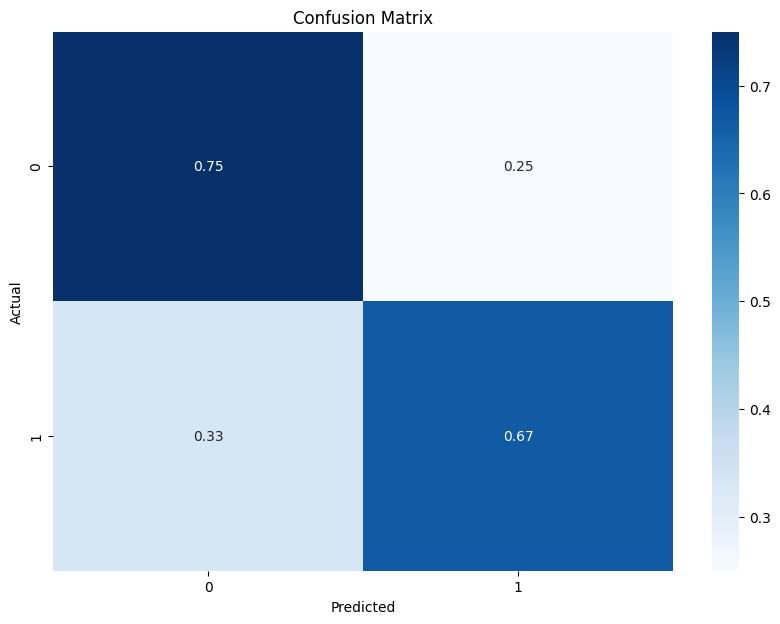

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])

# Create a heatmap from the DataFrame
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Div2vec

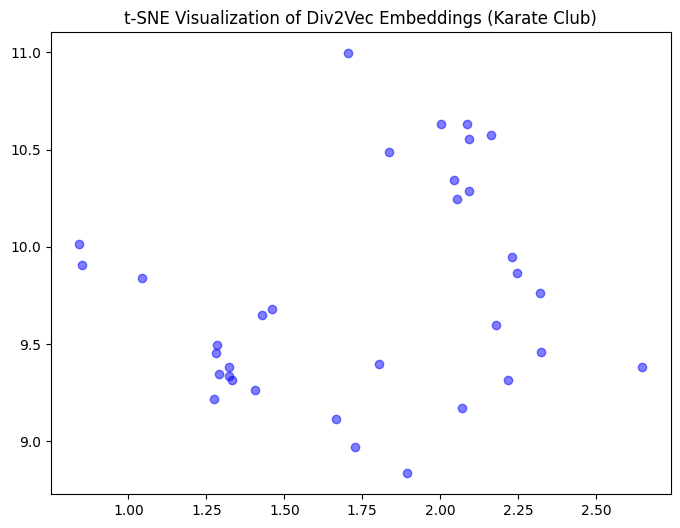

In [45]:
import numpy as np
import random
import networkx as nx
from sklearn.manifold import TSNE

class Word2Vec:
    def __init__(self, dimensions=128, window=5, learning_rate=0.025):
        self.dimensions = dimensions
        self.window = window
        self.learning_rate = learning_rate

    def initialize_weights(self, vocab_size):
        self.input_weights = np.random.uniform(-0.5 / self.dimensions, 0.5 / self.dimensions, (vocab_size, self.dimensions))
        self.output_weights = np.random.uniform(-0.5 / self.dimensions, 0.5 / self.dimensions, (vocab_size, self.dimensions))

    def train(self, corpus, epochs=1):
        vocab = set()
        for sentence in corpus:
            vocab.update(sentence)
        vocab = list(vocab)
        vocab_size = len(vocab)
        self.initialize_weights(vocab_size)

        for _ in range(epochs):
            for sentence in corpus:
                for i, target_word in enumerate(sentence):
                    target_index = vocab.index(target_word)
                    for j in range(max(0, i - self.window), min(len(sentence), i + self.window + 1)):
                        if j != i:
                            context_word = sentence[j]
                            context_index = vocab.index(context_word)
                            self.update_weights(target_index, context_index)

    def update_weights(self, target_index, context_index):
        input_vector = self.input_weights[target_index]
        output_vector = self.output_weights[context_index]
        score = np.dot(input_vector, output_vector)
        exp_score = np.exp(score)
        grad = exp_score / (1 + exp_score)
        grad = (1 - grad) * self.learning_rate
        self.input_weights[target_index] += grad * output_vector
        self.output_weights[context_index] += grad * input_vector

class Div2Vec:
    def __init__(self, graph, dimensions=128, walk_length=80, num_walks=10, p=1, q=1, diversity_factor=0.5):
        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.diversity_factor = diversity_factor
        self.embeddings = None

    def generate_walks(self):
        walks = []
        nodes = list(self.graph.nodes())
        for _ in range(self.num_walks):
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self._div2vec_walk(self.walk_length, node))
        return walks

    def _div2vec_walk(self, walk_length, start_node):
        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            neighbors = list(self.graph.neighbors(cur))
            if len(neighbors) > 0:
                if len(walk) == 1:
                    walk.append(random.choice(neighbors))
                else:
                    prev = walk[-2]
                    next_node = self._weighted_random_walk(cur, prev)
                    walk.append(next_node)
            else:
                break
        return walk

    def _weighted_random_walk(self, cur, prev):
        neighbors = list(self.graph.neighbors(cur))
        weights = [self._get_weight(cur, nbr, prev) for nbr in neighbors]
        return random.choices(neighbors, weights=weights)[0]

    def _get_weight(self, cur, nbr, prev):
        if prev == nbr:
            return 1 / self.p
        elif self.graph.has_edge(cur, nbr):
            return 1
        else:
            return 1 / self.q

    def learn_embeddings(self, walks):
        w2v = Word2Vec(dimensions=self.dimensions)
        w2v.train(walks)
        self.embeddings = {node: w2v.input_weights[i] for i, node in enumerate(self.graph.nodes())}
        self.embeddings = {node: self._diversify_embedding(self.embeddings[node], node) for node in self.embeddings}

    def _diversify_embedding(self, embedding, node):
        neighbors = list(self.graph.neighbors(node))
        neighbor_embeddings = [self.embeddings[n] for n in neighbors if n in self.embeddings]
        if len(neighbor_embeddings) > 0:
            diversity_vector = np.mean(neighbor_embeddings, axis=0) - embedding
            return embedding + self.diversity_factor * diversity_vector
        else:
            return embedding

# Load Karate Club dataset
G = nx.karate_club_graph()

# Initialize Div2Vec
div2vec = Div2Vec(G)

# Generate walks
walks = div2vec.generate_walks()

# Learn embeddings
div2vec.learn_embeddings(walks)

# Extract node embeddings
embeddings = np.array([div2vec.embeddings[node] for node in sorted(G.nodes())])

# Visualize embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(embeddings)

# Plot the embeddings
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for i in range(len(X_embedded)):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], c='b', label='Node', alpha=0.5)
plt.title('t-SNE Visualization of Div2Vec Embeddings (Karate Club)')
plt.show()
